### This notebook presents how to obtain number embeddings with NEKG.

<ul>
    <li> In <b>Section 3.1</b>, we construct the knowledge, generating 200 triples (e.g., ['0','isLessThan', '50'], ['100','isLessThan', '150'], etc.).</li><br>
    <li>In <b>Section 3.2</b>, we embed the graph in a 100-D vector space using a standard graph embedding method TransE. We visualize the embedding vectors using t-SNE in a 2-D space.</li><br>
    <li>In <b>Section 3.3</b>, we embed the integers from 500 to 1000 (i.e., [500, 1000)) using the interpolation method and visualize the embedding vectors using t-SNE in a 2-D space.</li>
</ul>




In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.latent_features import TransE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

<b>VERSION:</b>
<ul>
    <li>python 3.7.3</li>
    <li>tensorflow 1.15.0</li>
    <li>numpy 1.19.5</li>
    <li>ampligraph 1.3.2</li>
    <li>pandas 0.24.1</li>
    <li>sklearn 0.21.2</li>
    <li>matplotlib 3.4.2</li>
</ul>

### 3.1 Knowledge Graph Construction

In [2]:
# Knowledge Graph Construction.
def graph_construction(start, stop, step):
    kg = pd.DataFrame()
    kg['h'] = [i for i in np.arange(start, stop, step)]
    kg['r'] = ['isLessThan'] * int((stop-start) / step)
    kg['t'] = [i for i in np.arange(step, stop+1, step)]
    kg["h"] = kg.h.values.astype(str)
    kg["t"] = kg.t.values.astype(str)
    return kg

In [3]:
start = 0
stop = 10000
step = 50
kg_df = graph_construction(start, stop, step)
kg_df.head()

,h,r,t
0,0,isLessThan,50
1,50,isLessThan,100
2,100,isLessThan,150
3,150,isLessThan,200
4,200,isLessThan,250


### 3.2 Knowledge Graph Embedding

In [4]:
kg_array = kg_df.to_numpy().astype(str)
model = TransE(epochs=200, k=100, verbose=True)
model.fit(kg_array)

Average Loss:   1.029354: 100%|██████████| 200/200 [00:34<00:00,  5.80epoch/s]


In [5]:
# Obtain the embedding vector of 100.
embedding = model.get_embeddings(entities='100', embedding_type='entity')
embedding

array([-0.03253812, -0.02000681,  0.05491443, -0.0167523 ,  0.04375741,
       -0.05762373, -0.07576536, -0.01016981, -0.04103467,  0.02172747,
       -0.02696225, -0.03462287,  0.01686343, -0.05085032,  0.05295955,
        0.0714102 , -0.01149047, -0.06509489, -0.02062051, -0.04386297,
       -0.00369916,  0.05311249, -0.03737329, -0.04172274, -0.0634738 ,
       -0.02999266,  0.08699155,  0.0311297 ,  0.04634103, -0.06518105,
       -0.02427567, -0.05253655,  0.04664126,  0.00236646,  0.01852873,
       -0.06070972,  0.01063794, -0.00413415, -0.04776912, -0.05185708,
        0.03776143,  0.04242578,  0.01552047, -0.0058409 ,  0.00192816,
        0.01387468,  0.03621204, -0.05906281,  0.04190909, -0.03518984,
       -0.04083177,  0.0096988 , -0.01894604,  0.03559964,  0.00184189,
       -0.07784983,  0.02847837, -0.03657122, -0.02703886,  0.03409151,
       -0.02801519, -0.10430674,  0.02695868, -0.02996791,  0.00074281,
       -0.02776949, -0.03605617, -0.04025631,  0.0253182 ,  0.07

In [6]:
# Dimensionality reduction using t-SNE.
embeddings = model.get_embeddings(entities=[str(j) for j in np.arange(start, stop+1, step)], embedding_type='entity')
embeddings = np.asarray(embeddings, dtype='float64')
embeddings_tSNE = TSNE(n_components=2).fit_transform(embeddings)
embeddings_tSNE = pd.DataFrame(embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
embeddings_tSNE['magnitude'] = [i for i in range(start, stop+1, step)]
embeddings_tSNE.head()

,tSNE_1,tSNE_2,magnitude
0,-10.110653,15.051889,0
1,-10.066402,14.979128,50
2,-10.272236,14.963172,100
3,-9.997298,14.732146,150
4,-10.472224,14.801786,200


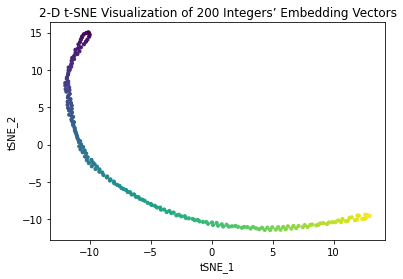

In [7]:
# Visualize the embedding vectors in 2-D space.
plt.scatter(embeddings_tSNE.tSNE_1, embeddings_tSNE.tSNE_2, c=embeddings_tSNE.magnitude, s=10)
plt.title('2-D t-SNE Visualization of 200 Integers’ Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

### 3.3 Interpolation Method

In [8]:
# Measure the similarity between numbers.
def cal_sim(x1, x2, x3):
    return (x2-x1)/(x3-x1)

In [9]:
# Obtain embedding vectors for OOVs.
OOVs = range(500, 1000)
OOV_embeddings = []
for i in OOVs:
    for j in np.arange(start, stop+1, step):
        if i < j:
            upper = j
            lower = j-step
            e1 = model.get_embeddings(str(lower), embedding_type='entity')
            e2 = model.get_embeddings(str(upper), embedding_type='entity')
            s2 = cal_sim(lower, i, upper)
            s1 = 1-s2            
            OOV_embeddings.append(e1 * s1 + e2 * s2)
            break

In [10]:
# Dimensionality reduction using t-SNE.
OOV_embeddings = np.asarray(OOV_embeddings, dtype='float64')
OOV_embeddings_tSNE = TSNE(n_components=2).fit_transform(OOV_embeddings)
OOV_embeddings_tSNE = pd.DataFrame(OOV_embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
OOV_embeddings_tSNE['magnitude'] = OOVs
OOV_embeddings_tSNE.head()

,tSNE_1,tSNE_2,magnitude
0,-30.995590,2.480355,500
1,-30.851843,2.485485,501
2,-31.154890,2.784283,502
3,-31.151619,2.900439,503
4,-30.544378,2.652500,504


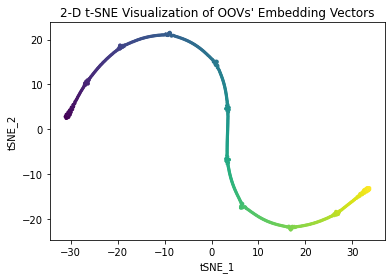

In [11]:
# Visualize the embedding vectors of OOVs in 2-D space.
plt.scatter(OOV_embeddings_tSNE.tSNE_1, OOV_embeddings_tSNE.tSNE_2, c=OOV_embeddings_tSNE.magnitude, s=5)
plt.title('2-D t-SNE Visualization of OOVs\' Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()